In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import torch

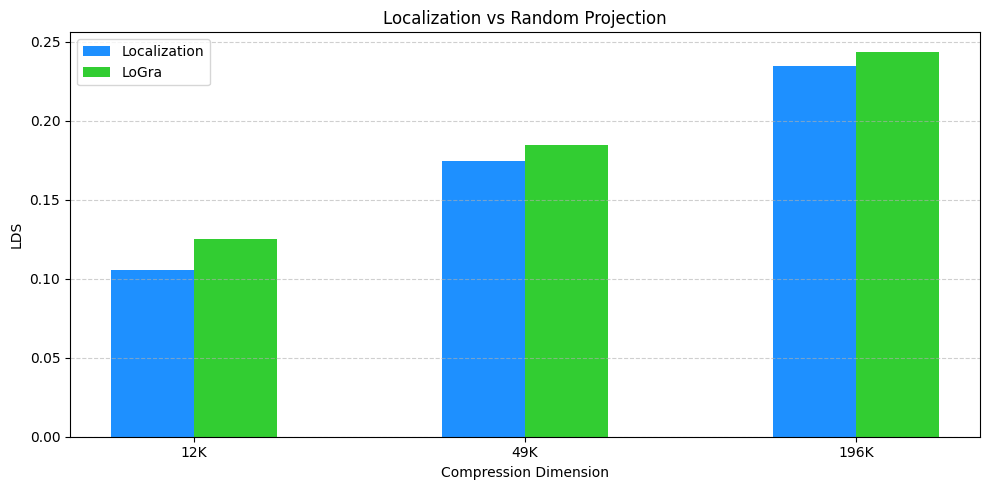

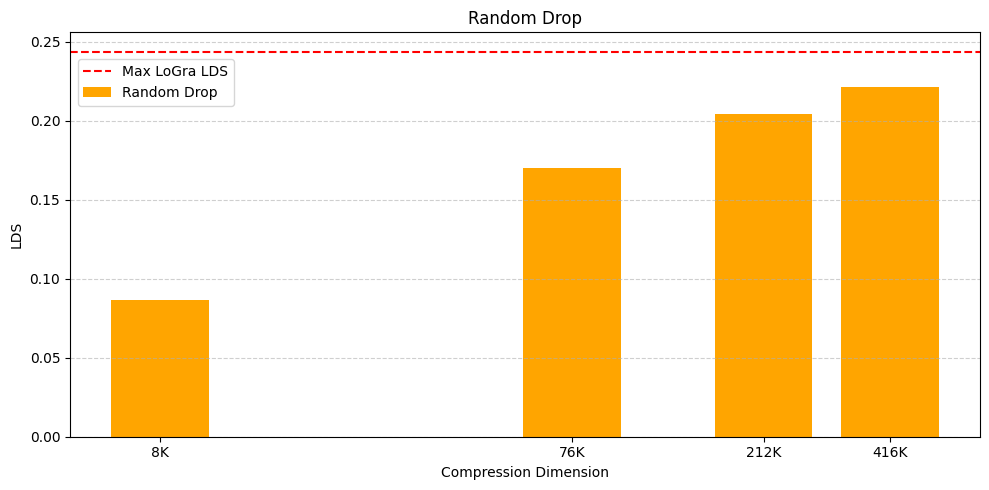

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import torch

# === Configs ===
results_dir = "./results"
train_setting = "wd=0.0_lr=5e-5"
total_params = 85017600
num_layers = 48
methods = ["Localize-16*16", "Localize-32*32", "Localize-64*64",
           "Random Drop-0.93", "Random Drop-0.95", "Random Drop-0.97", "Random Drop-0.99",
           "LoGra-16*16", "LoGra-32*32", "LoGra-64*64"]
result_file = ["GC/IF-RAW/Linear/Localize-16*16_thrd-0.0_rdp-0.0.pt", "GC/IF-RAW/Linear/Localize-32*32_thrd-0.0_rdp-0.0.pt", "GC/IF-RAW/Linear/Localize-64*64_thrd-0.0_rdp-0.0.pt",
               "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.93.pt", "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.95.pt", "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.97.pt", "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.99.pt",
               "LoGra/IF-RAW/Linear/Random-16*16_thrd-0.0_rdp-0.0.pt", "LoGra/IF-RAW/Linear/Random-32*32_thrd-0.0_rdp-0.0.pt", "LoGra/IF-RAW/Linear/Random-64*64_thrd-0.0_rdp-0.0.pt"]
# Updated legend names
group_display_names = {
    "Localize": "Localization",
    "Random Drop": "Random Drop",
    "LoGra": "LoGra"
}
group_colors = {
    "Localize": "dodgerblue",
    "Random Drop": "orange",
    "LoGra": "limegreen"
}

# === Step 1: Collect LDS results ===
data_by_proj_dim = defaultdict(dict)
data_by_group = defaultdict(dict)
max_logra_lds = 0

for idx, method in enumerate(methods):
    filename = os.path.join(results_dir, train_setting, result_file[idx])
    # Determine group and projection ratio
    if "Localize" in method:
        group = "Localize"
        dim = int(method.split("-")[1].split("*")[0])
        proj_dim = num_layers * dim * dim
        ratio = proj_dim / total_params
    elif "LoGra" in method:
        group = "LoGra"
        dim = int(method.split("-")[1].split("*")[0])
        proj_dim = num_layers * dim * dim
        ratio = proj_dim / total_params
    elif "Random Drop" in method:
        group = "Random Drop"
        drop_rate = float(method.split("-")[1])
        # Note: adjusting ratio calculation as per your instruction
        ratio = (1 - drop_rate) ** 2
        proj_dim = int(ratio * total_params)
    else:
        continue

    if os.path.exists(filename):
        data = torch.load(filename, weights_only=False)
        lds = data.get("lds", None)
        if lds is not None:
            data_by_proj_dim[proj_dim][group] = lds
            data_by_group[group][proj_dim] = lds

            # Track maximum LoGra LDS
            if group == "LoGra" and lds > max_logra_lds:
                max_logra_lds = lds
        else:
            print(f"Warning: 'lds' not found in {filename}")
    else:
        print(f"Warning: File not found: {filename}")

# Function to prepare x positions based on log scale
def prepare_x_positions(dimensions):
    log_dims = [math.log10(d) for d in dimensions]
    min_log = min(log_dims)
    max_log = max(log_dims)
    # Normalize to get evenly spaced positions based on log scale
    normalized_positions = [(ld - min_log) / (max_log - min_log) * (len(dimensions) - 1) for ld in log_dims]
    return np.array(normalized_positions)

# Function to format dimension labels
def format_dimension_labels(dimensions):
    dim_labels = []
    for d in dimensions:
        if d < 1000:
            dim_labels.append(f"{int(d)}")
        elif d < 1_000_000:
            dim_labels.append(f"{int(d/1000)}K")
        else:
            dim_labels.append(f"{d/1_000_000:.2f}M")
    return dim_labels

# === Plot 1: Localize and LoGra together ===
plt.figure(figsize=(10, 5))
# Get the dimensions for Localize and LoGra groups only
plot1_dims = sorted(set([d for d in data_by_proj_dim.keys()
                     if "Localize" in data_by_proj_dim[d] or "LoGra" in data_by_proj_dim[d]]))
x1 = prepare_x_positions(plot1_dims)
bar_width = 0.25  # Wider since we have fewer groups per dimension

legend_shown = set()
for i, dim in enumerate(plot1_dims):
    groups = [g for g in data_by_proj_dim[dim].keys() if g in ["Localize", "LoGra"]]
    num_groups = len(groups)
    start = x1[i] - (num_groups - 1) * bar_width / 2
    for j, group in enumerate(groups):
        lds = data_by_proj_dim[dim][group]
        xpos = start + j * bar_width
        # Use the display name for the legend instead of the internal group name
        label = group_display_names[group] if group not in legend_shown else None
        plt.bar(xpos, lds, width=bar_width, color=group_colors[group], label=label)
        legend_shown.add(group)

plt.xticks(x1, format_dimension_labels(plot1_dims))
plt.xlabel("Compression Dimension")
plt.ylabel("LDS")
plt.title("Localization vs Random Projection")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Plot 2: Random Drop with LoGra max line ===
plt.figure(figsize=(10, 5))
# Get the projection dimensions for Random Drop only
plot2_dims = sorted([d for d in data_by_proj_dim.keys() if "Random Drop" in data_by_proj_dim[d]])
x2 = prepare_x_positions(plot2_dims)
bar_width = 0.4  # Wider since we only have one group per dimension

# Plot Random Drop bars
for i, dim in enumerate(plot2_dims):
    lds = data_by_proj_dim[dim]["Random Drop"]
    plt.bar(x2[i], lds, width=bar_width, color=group_colors["Random Drop"],
            label=group_display_names["Random Drop"] if i == 0 else None)

# Add horizontal dashed line for max LoGra LDS
plt.axhline(y=max_logra_lds, linestyle='--', color='red',
            label=f"Max {group_display_names['LoGra']} LDS")

plt.xticks(x2, format_dimension_labels(plot2_dims))
plt.xlabel("Compression Dimension")
plt.ylabel("LDS")
plt.title("Random Drop")
plt.legend(loc='upper left', bbox_to_anchor=(0.001, 0.95))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()